In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pathlib
import sklearn 
from sksurv.functions import StepFunction
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import cumulative_dynamic_auc 
from model_evaluation import evaluate_model
from sksurv.column import encode_categorical
from sksurv.ensemble import RandomSurvivalForest
from dotenv import load_dotenv
import os

In [2]:
load_dotenv()
root = os.environ.get("root_folder")

In [3]:
from preprocessing import readcounts_processing_pipeline, pheno_processing_pipeline, prepare_train_test, remove_unique_columns
from HosmerLemeshow import HosmerLemeshow, reformat_inputs

 
pheno_df_train = pd.read_csv(root + '/train/pheno_training.csv')
pheno_df_train = pheno_processing_pipeline(pheno_df_train)

pheno_df_test = pd.read_csv(root + '/test/pheno_test.csv')
pheno_df_test = pheno_processing_pipeline(pheno_df_test)

readcounts_df_train = pd.read_csv(root + '/train/readcounts_training.csv')
readcounts_df_train = readcounts_processing_pipeline(readcounts_df_train)

readcounts_df_test = pd.read_csv(root + '/test/readcounts_test.csv')
readcounts_df_test = readcounts_processing_pipeline(readcounts_df_test)


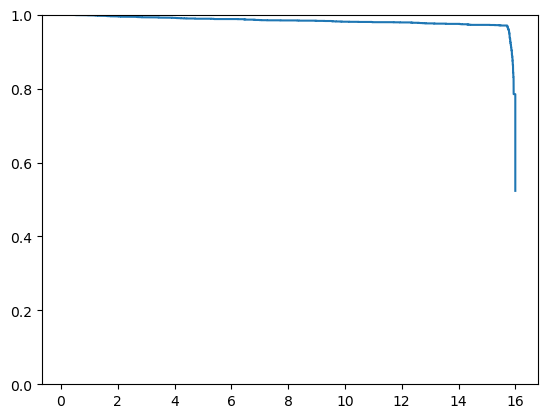

In [14]:
from sksurv.nonparametric import kaplan_meier_estimator
covariates = ['Sex=1', 'Age']
X_train, X_test, y_train, y_test, test_sample_ids = prepare_train_test(pheno_df_train, pheno_df_test, covariates)

x, y = kaplan_meier_estimator(y_train.Event, y_train.Event_time)
 
plt.step(x, y, where="post")

plt.ylim(0, 1)

plt.show()

## Start with a baseline model 
     

In [31]:
pheno_df = pd.concat([pheno_df_train, pheno_df_test])
pheno_df = pheno_df.loc[pheno_df.Event_time > 0]
t0 = pheno_df['Event_time'].min()
tf = pheno_df['Event_time'].max()

times = np.linspace(t0, tf, 15)
times = times[1:-1]

In [9]:
def plot_cumulative_dynamic_auc(risk_score, label, color=None):
    auc, mean_auc = cumulative_dynamic_auc(y_train, y_test, risk_score, times)

    plt.plot(times, auc, marker="o", color=color, label=label)
    plt.xlabel("days from enrollment")
    plt.ylabel("time-dependent AUC")
    plt.axhline(mean_auc, color=color, linestyle="--")
    plt.legend()

### Cox model with only Age + Sex covariates

In [77]:
import warnings
warnings.filterwarnings("error")


In [81]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3448 entries, Simulated_328 to Simulated_1731
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Sex=1   3448 non-null   float64
 1   Age     3448 non-null   Float64
dtypes: Float64(1), float64(1)
memory usage: 213.2+ KB


In [83]:
base_model = CoxPHSurvivalAnalysis(alpha=0, ties='breslow', n_iter=100, tol=1e-09, verbose=0)
  
covariates = ['Sex=1', 'Age']

X_train, X_test, y_train, y_test, test_sample_ids = prepare_train_test(pheno_df_train, pheno_df_test, covariates)

base_model.fit(X_train, y_train)

evaluate_model(base_model, X_train, X_test, y_train, y_test)

FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.

In [59]:
#First, we are going to check whether the observed time of the test data lies within the observed time range of the training data.

y_events = y_train[y_train['Event']]
train_min, train_max = y_events["Event_time"].min(), y_events["Event_time"].max()

y_events = y_test[y_test['Event']]
test_min, test_max = y_events["Event_time"].min(), y_events["Event_time"].max()

assert train_min <= test_min < test_max <= train_max, \
    "time range or test data is not within time range of training data."

assert train_min <= test_min < test_max < train_max, \
"time range or test data is not within time range of training data."


cumulative_dynamic_auc_train = cumulative_dynamic_auc(y_train, y_train, preds_train, times)

cumulative_dynamic_auc_test = cumulative_dynamic_auc(y_train, y_test, preds_test, times)

 


ValueError: censoring survival function is zero at one or more time points

Plot the estimated survival function

/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


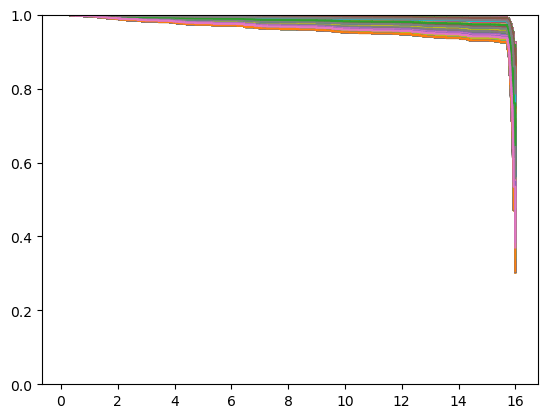

In [ ]:
S = base_model.predict_survival_function(X_train)

for fn in S:
    plt.step(fn.x, fn(fn.x), where="post")
plt.ylim(0, 1)
plt.show()

### Cox model with all clinical covariates

In [71]:
base_model = CoxPHSurvivalAnalysis(alpha=0, ties='breslow', n_iter=100, tol=1e-09, verbose=0)

covariates = ['Age', 'BodyMassIndex', 'Smoking=1', 'BPTreatment=1',
       'PrevalentDiabetes=1', 'PrevalentCHD=1', 'SystolicBP', 'NonHDLcholesterol', 'Sex=1']

X_train, X_test, y_train, y_test, test_sample_ids = prepare_train_test(pheno_df_train, pheno_df_test, covariates)

base_model.fit(X_train, y_train)

evaluate_model(base_model, X_train, X_test, y_train, y_test)

/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert yo

,Harrell C,Concordance index IPCW,Integrated Brier Score
train,0.715808,0.666960,0.019731
test,0.708009,0.656452,0.017514


### Random forest survival model with all clinical covariates + microbiome data

In [72]:
readcounts_df_train, readcounts_df_test = remove_unique_columns(readcounts_df_train, readcounts_df_test)

In [74]:
df_train = pheno_df_train.join(readcounts_df_train)
df_test = pheno_df_test.join(readcounts_df_test)
base_model = RandomSurvivalForest(n_estimators=100, max_depth=None, min_samples_split=6, min_samples_leaf=3)  

covariates = df_train.columns                   
X_train, X_test, y_train, y_test, test_sample_ids = prepare_train_test(df_train, df_test, covariates)

base_model.fit(X_train, y_train)

evaluate_model(base_model, X_train, X_test, y_train, y_test)

/home/tristan/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)


,Harrell C,Concordance index IPCW,Integrated Brier Score
train,0.995144,0.992738,0.008423
test,0.972914,0.970731,0.014511


In [ ]:
preds_train = base_model.predict(X_train)
data = reformat_inputs(X_train, preds_train)
HL_test = HosmerLemeshow(data, preds_train, Q=10)

AttributeError: 'numpy.ndarray' object has no attribute 'p1'

correct adjustment for the age at
entry is crucial in reducing bias of the estimated
coefficients.Using “age-as-the-time scale”
instead of “time-on-follow-up”
Reason: account for left trun-
cation of age
Cox PH model that adjusts for
age truncation:

In [ ]:
import rpy2.robjects as ro
path='./src/hosmerTest.R'

def function1(input,output):
    r=ro.r
    r.source(path+"rtest.R")
    p=r.rtest(input,output)
    return p

ModuleNotFoundError: No module named 'rpy2'